In [1]:

# Necessary Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate,GridSearchCV,validation_curve,cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,RocCurveDisplay,classification_report,roc_curve
import warnings
warnings.simplefilter("ignore")


In [2]:
df=pd.read_csv("Telco-Customer-Churn.csv")

df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
def check_df(dataframe,head=4):
    print("################################ Shape ###########################################################")
    print(dataframe.shape)
    print("################################ Types ###########################################################")
    print(dataframe.dtypes)
    print("################################ Missing Values ###########################################################")
    print(dataframe.isnull().sum())
    print("################################ Head ###########################################################")
    print(dataframe.head(head))
    print("################################ Tail ###########################################################")
    print(dataframe.tail(head))
    print("################################ Quantiles ###########################################################")
    print(dataframe.describe([0,0.05,0.50,0.95,0.99,1]).T)


check_df(df)

################################ Shape ###########################################################
(7043, 21)
################################ Types ###########################################################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
################################ Missing Values ###########################################################
customerID          0
gender              0
SeniorCitizen       0
Partner        

In [4]:
df.drop("customerID",axis=1,inplace=True)
df["Churn"]=df["Churn"].apply(lambda x: 1 if x=="Yes" else 0 )
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')



We removed unimportant feature "CustomerID. And ensuring correct data types for analysis.

In [5]:
# DETECTION OF NUMERIC AND CATEGORICAL VARIABLES
def grab_col_names(dataframe, cat_th=10, car_th=20):
   
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols,num_cols,cat_but_car=grab_col_names(df)

Observations: 7043
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 2


count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64


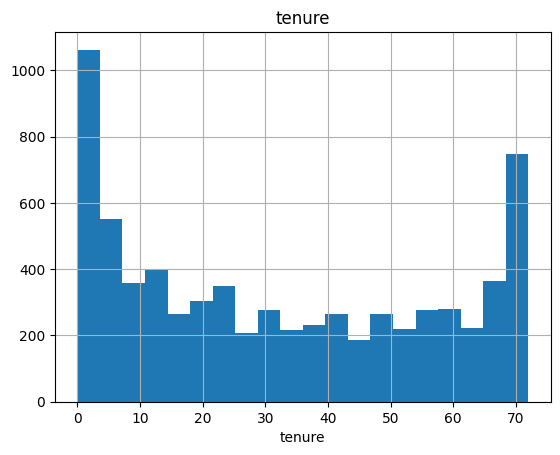

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64


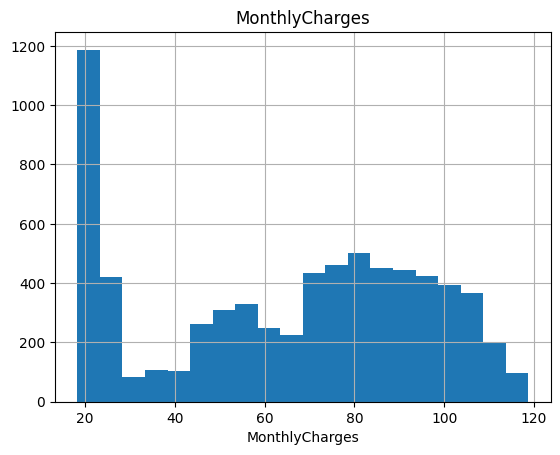

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: TotalCharges, dtype: float64


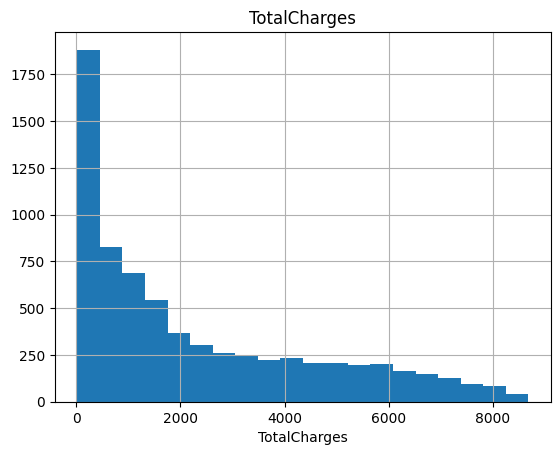

In [6]:
#Analysis of Numerical Variables
def num_summary(dataframe,numerical_col,plot=False):
    quantiles= [0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df,col,plot=True)

When we look at the histogram graphing of numerical variables, we see some big values. To improve machine learning models
, we can standardize them.

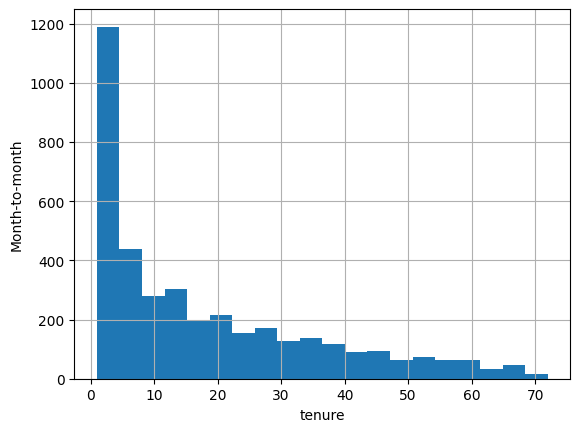

In [7]:

df[df["Contract"]=="Month-to-month"]["tenure"].hist(bins=20)
plt.xlabel("tenure")
plt.ylabel("Month-to-month")
plt.show()

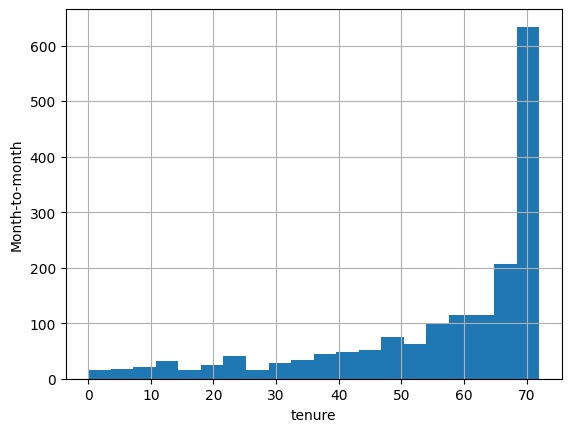

In [8]:

df[df["Contract"]=="Two year"]["tenure"].hist(bins=20)
plt.xlabel("tenure")
plt.ylabel("Month-to-month")
plt.show()

When we look at the tenures, we see that the 1-month and 70-month tenures are predominant compared to the others.

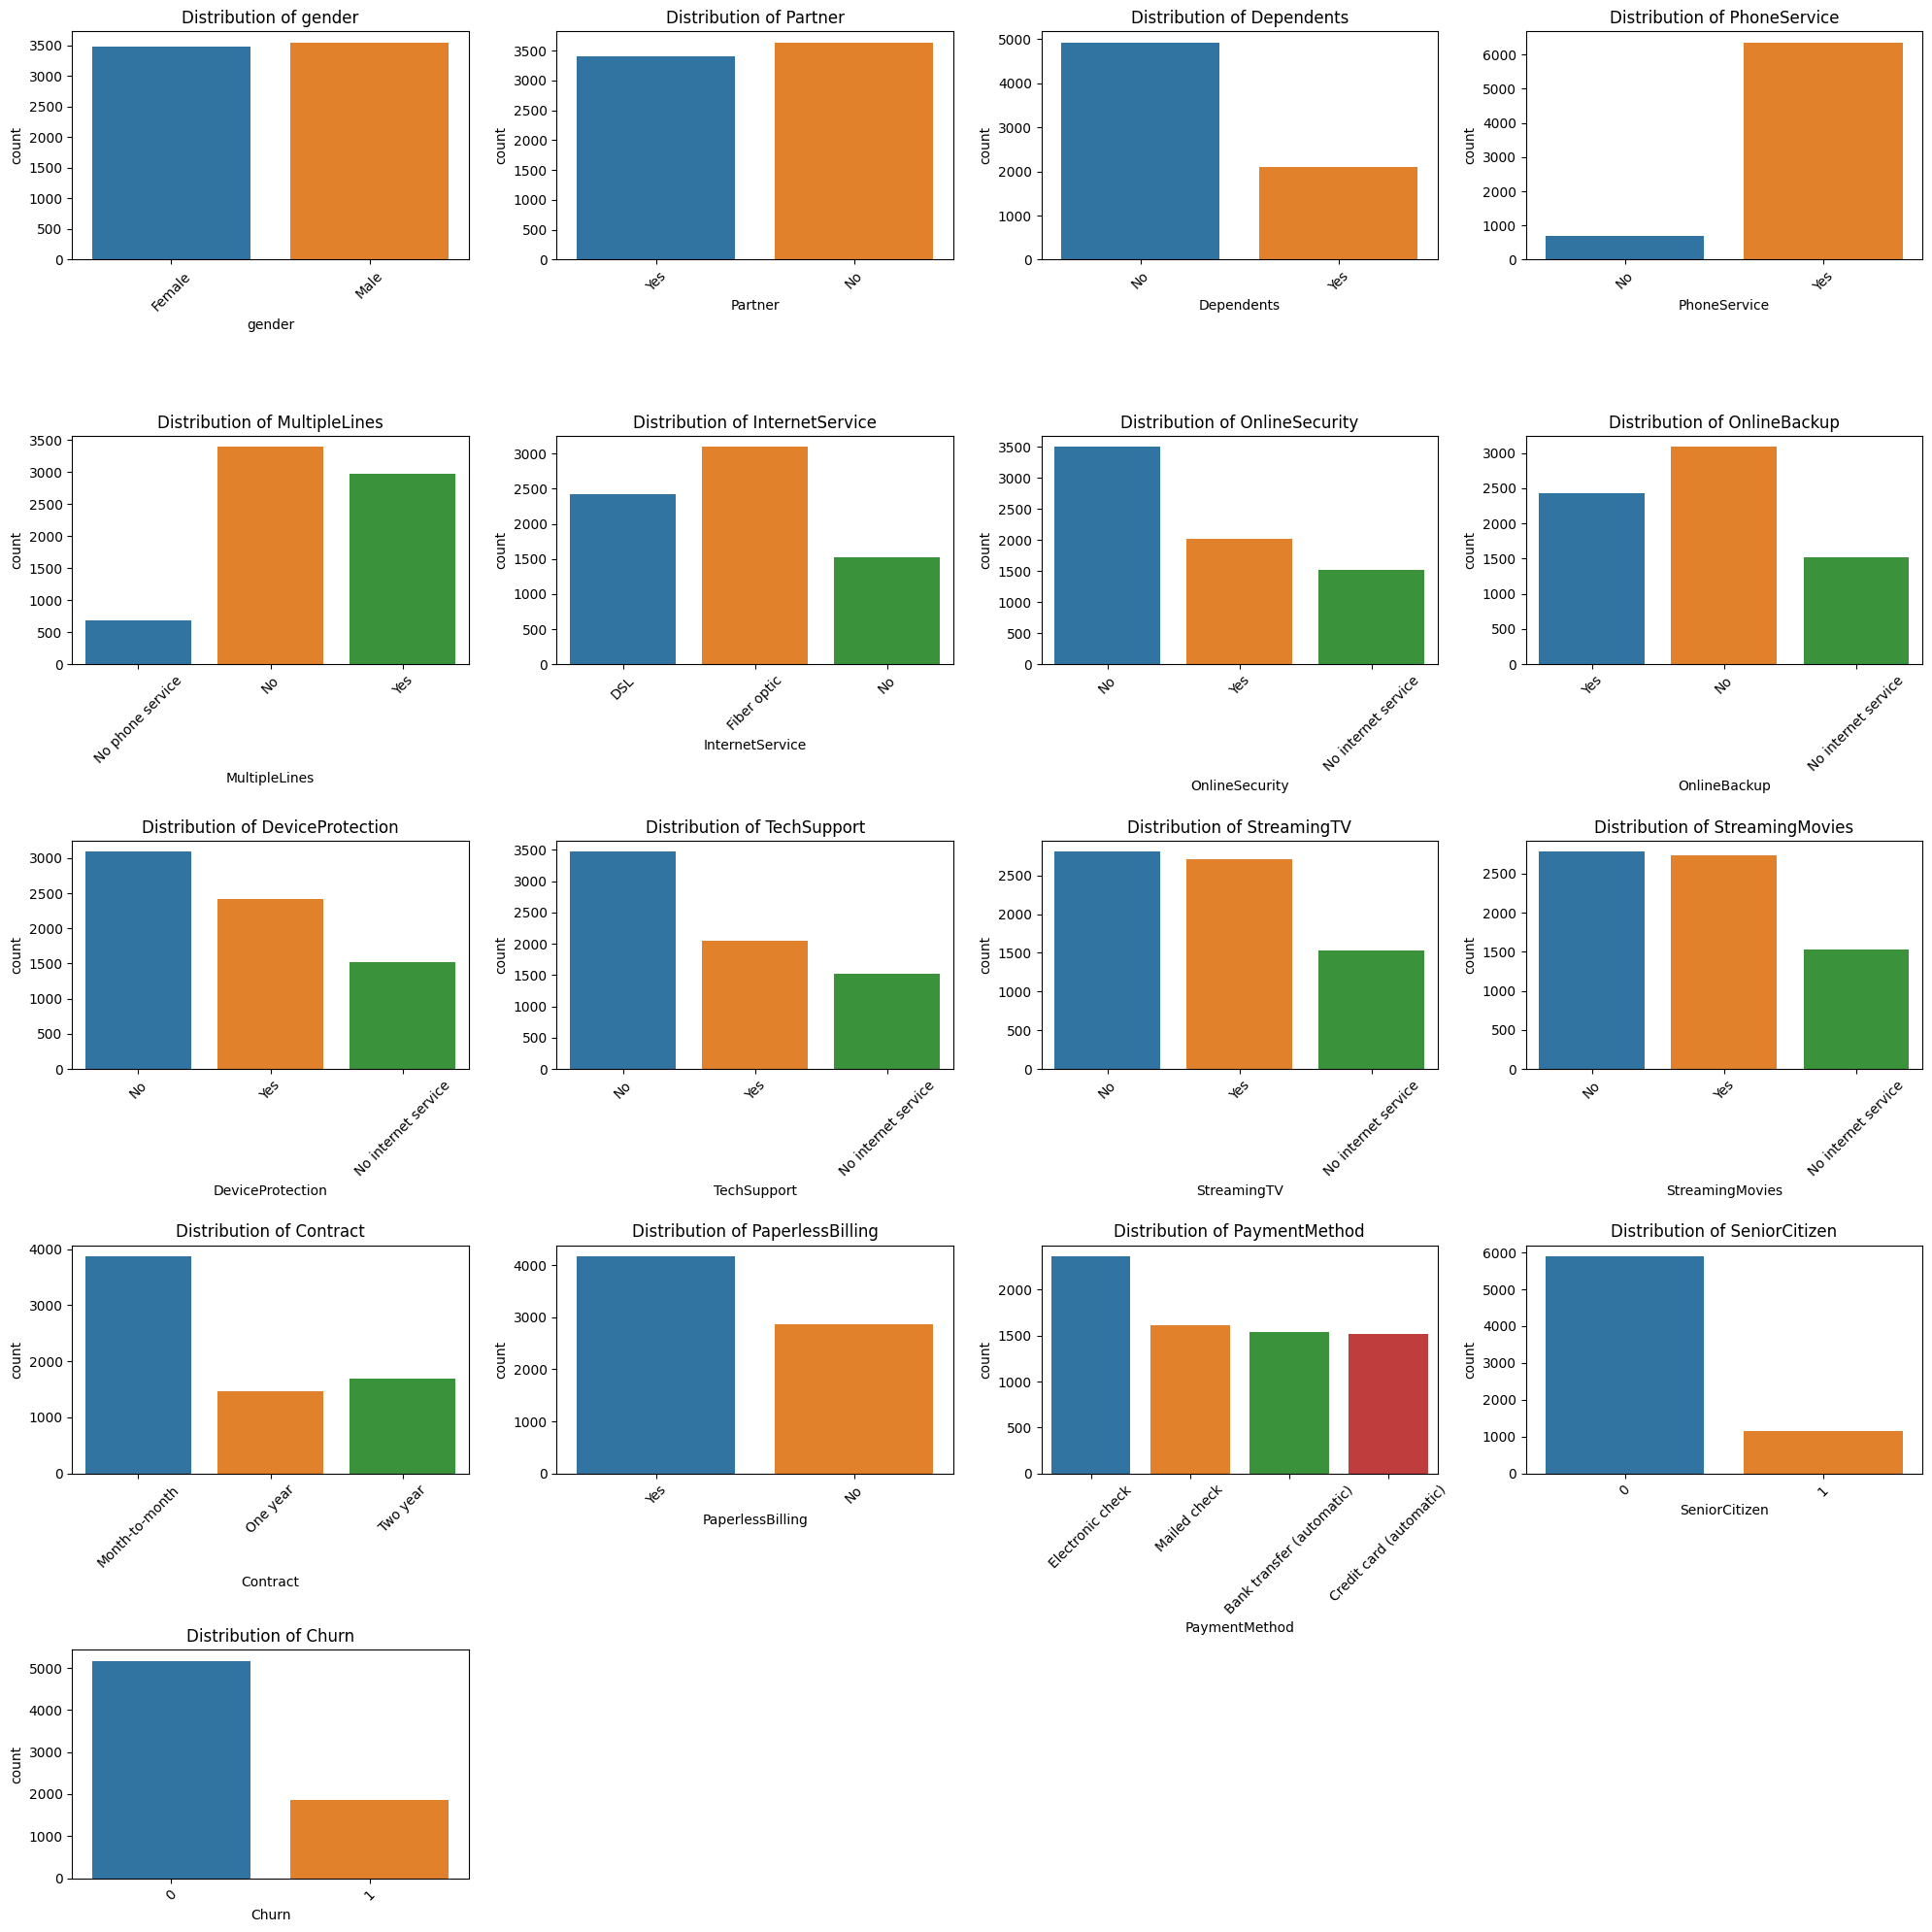

In [9]:
#Analysis of Categorical Variables
def cat_summary(dataframe, cat_cols, plot=True):
    if plot:
        num_cols = 4  
        num_rows = (len(cat_cols) // num_cols) + (len(cat_cols) % num_cols > 0) 
        
        plt.figure(figsize=(num_cols * 5, num_rows * 4))  
        
        for i, col in enumerate(cat_cols):
            plt.subplot(num_rows, num_cols, i + 1) 
            sns.countplot(x=dataframe[col], data=dataframe)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
        
        plt.show()

cat_summary(df, cat_cols=cat_cols)

Churn has an imbalanced distribution. We will handle data imbalance for better precision ,recall and f1 scores.

In [10]:

def target_summary_with_num(dataframe,col_name,target):
    print(dataframe.groupby(target)[col_name].mean(),end="\n\n\n")
for col in num_cols:
    target_summary_with_num(df,col,"Churn")



Churn
0    37.569965
1    17.979133
Name: tenure, dtype: float64


Churn
0    61.265124
1    74.441332
Name: MonthlyCharges, dtype: float64


Churn
0    2555.344141
1    1531.796094
Name: TotalCharges, dtype: float64




In [11]:
def target_summary_with_cat(dataframe,target,col_name):
   print( pd.DataFrame({"Target_Mean":dataframe.groupby(col_name)[target].mean()}),end="\n\n\n")
for col in cat_cols:
   target_summary_with_cat(df,"Churn",col)

        Target_Mean
gender             
Female     0.269209
Male       0.261603


         Target_Mean
Partner             
No          0.329580
Yes         0.196649


            Target_Mean
Dependents             
No             0.312791
Yes            0.154502


              Target_Mean
PhoneService             
No               0.249267
Yes              0.267096


                  Target_Mean
MultipleLines                
No                   0.250442
No phone service     0.249267
Yes                  0.286099


                 Target_Mean
InternetService             
DSL                 0.189591
Fiber optic         0.418928
No                  0.074050


                     Target_Mean
OnlineSecurity                  
No                      0.417667
No internet service     0.074050
Yes                     0.146112


                     Target_Mean
OnlineBackup                    
No                      0.399288
No internet service     0.074050
Yes                     0.2153

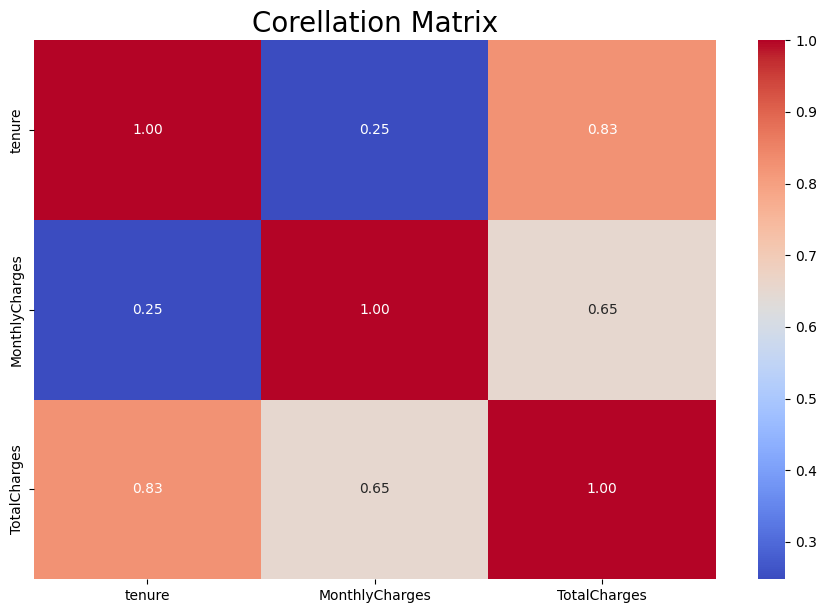

In [12]:

corr=df[num_cols].corr()
f, ax=plt.subplots(figsize=[11,7])
sns.heatmap(corr,annot=True,fmt=".2f",ax=ax,cmap="coolwarm")
ax.set_title("Corellation Matrix",fontsize=20)
plt.show()



TotalCharges and tenure are highly correlated

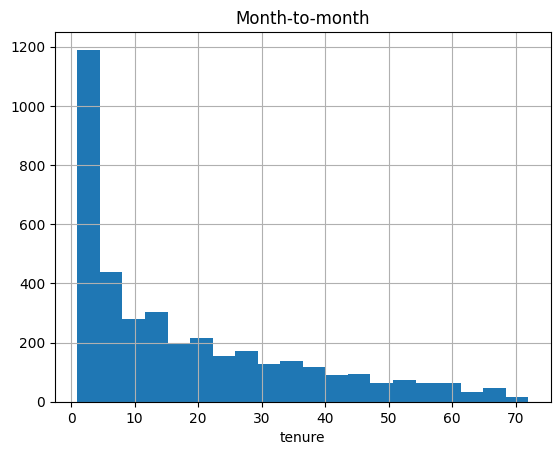

In [13]:
df[df["Contract"] == "Month-to-month"]["tenure"].hist(bins=20)
plt.xlabel("tenure")
plt.title("Month-to-month")
plt.show()


In [14]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [15]:
def missing_values_table(dataframe,na_name=False):
    na_columns=[col for col in dataframe.columns if dataframe[col].isnull().sum()>0]
    n_miss=dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    n_ratio=(dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df=pd.concat([n_miss,np.round(n_ratio,2)],axis=1,keys=['n_miss', 'ratio'])
    print(missing_df,end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

    

              n_miss  ratio
TotalCharges      11   0.16


In [16]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True) 

df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
######Base model building###########
dff=df.copy()
cat_cols_dff,num_cols_dff,cat_but_car_dff=grab_col_names(dff)
cat_cols_dff=[col for col in cat_cols_dff if col not in ["Churn"]]

def one_hot_encoder(dataframe,categorical_col,drop_first=False):
    dataframe=pd.get_dummies(data=dataframe,columns=categorical_col,drop_first=drop_first,dtype=int)
    return dataframe
dff=one_hot_encoder(dff,cat_cols_dff)

X=dff.drop("Churn",axis=1)
y=dff["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

models = [
    ("LR", LogisticRegression(random_state=12345)),
    ("KNN", KNeighborsClassifier()),
    ("CART", DecisionTreeClassifier(random_state=12345)),
    ("RF", RandomForestClassifier()),
    ("SVM", SVC(gamma="auto", probability=True, random_state=12345)),  # SVM için probability=True ekleyin
    ("XGB", XGBClassifier(random_state=12345)),
    ("LGM", LGBMClassifier(random_state=12345)),
    ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))
]

models_df = pd.DataFrame(columns=['Model', " Accuracy", ' f1', ' Precision', ' Recall', ' ROC AUC'])

for name, model in models:
    model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_test)
    
   
   
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(classification_report(y_test,y_pred))
    
   
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = "N/A"  

    
    models_df.loc[len(models_df)] = [name, accuracy, f1, precision, recall, roc_auc]



    



Observations: 7043
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 2
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1030
           1       0.67      0.53      0.59       379

    accuracy                           0.80      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1030
           1       0.61      0.47      0.53       379

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.78      0.77      1409

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1030
           1       0.50      0.53      0.51       379

    accuracy                           0.73      1409
   macro avg       0.66      0.67      0

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1030
           1       0.66      0.49      0.56       379

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1030
           1       0.61      0.31      0.41       379

    accuracy                           0.76      1409
   macro avg       0.70      0.62      0.63      1409
weighted avg       0.74      0.76      0.73      1409

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1030
           1       0.62      0.51      0.56       379

    accuracy                           0.78      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409

[LightGBM] [Warning

Since our data has an imbalanced distribution, looking only at accuracy can be misleading. It is important to also consider precision, F1 score, and recall.

In [18]:
######################################
# Outlier analysis
######################################

def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    quartile1=dataframe[col_name].quantile(q1)
    quartile3=dataframe[col_name].quantile(q3)
    interquantile_range=quartile3-quartile1
    up_limit= quartile3 + 1.5*interquantile_range
    low_limit=quartile1 - 1.5*interquantile_range
    return low_limit,up_limit

def check_outlier(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    if  dataframe[(dataframe[col_name]<low_limit) | (dataframe[col_name]>up_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    dataframe.loc[(dataframe[col_name]< low_limit),col_name]=low_limit
    dataframe.loc[(dataframe[col_name]>up_limit),col_name]=up_limit



for col in num_cols:
    print(check_outlier(df,col))



False
False
False


In [19]:
for col in num_cols:
    replace_with_thresholds(df,col)

for col in num_cols:
    print(check_outlier(df,col))


False
False
False


In [20]:
####Feature Exactring#############

df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

df["NEW_Engaged"]=df["Contract"].apply(lambda x:1 if x in ["One year","Two year"] else 0)
df["NEW_noProt"]=df.apply( lambda x:1 if (x["OnlineBackup"]!="Yes") or (x["DeviceProtection"]!="Yes") or (x["TechSupport"] != "Yes") else 0,axis=1)
df["NEW_Young_NotEngaged"]=df.apply(lambda x:1 if (x["SeniorCitizen"]==0) and (x["NEW_Engaged"] == 0) else 0,axis=1)
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)
df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)
df.replace('No internet service', 'No', inplace=True)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_NotEngaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,0-1 Year,0,1,1,1,0,0,14.925000,0.500000,14.9250
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,2-3 Year,1,1,0,3,0,0,53.985714,0.947949,14.2375
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,0-1 Year,0,1,1,3,0,0,36.050000,0.669452,13.4625
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,3-4 Year,1,1,0,3,0,1,40.016304,0.946012,10.5750
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,0-1 Year,0,1,1,1,0,0,50.550000,0.714993,35.3500


In [21]:
cat_cols,num_cols,cat_but_car=grab_col_names(df)

Observations: 7043
Variables: 30
cat_cols: 24
num_cols: 6
cat_but_car: 0
num_but_cat: 8


In [22]:
#Encoding

#label encoding
def label_encoder(dataframe,binary_col):
    labelencoder=LabelEncoder()
    dataframe[binary_col]=labelencoder.fit_transform(dataframe[binary_col])
    return dataframe                                                           

binary_cols=[col for col in df.columns if df[col].dtype=="O"and df[col].nunique()==2]
binary_cols

print(binary_cols)

for col in binary_cols:
    label_encoder(df,col)


['gender', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']


In [23]:

#one-hot encoding
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first,dtype=int)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df

,gender,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_NotEngaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1
0,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1,0,0,34,1,1,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0
2,1,0,0,2,1,1,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,1,0,0,45,0,1,0,1,1,0,...,0,1,0,0,0,1,1,0,0,1
4,0,0,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,1,24,1,1,0,1,1,1,...,0,0,0,0,0,1,1,0,1,0
7039,0,1,1,72,1,0,1,1,0,1,...,0,0,0,1,0,1,1,0,1,1
7040,0,1,1,11,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
7041,1,1,0,4,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [24]:


scaler = StandardScaler()
columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[columns_to_scale]=scaler.fit_transform(df[columns_to_scale])


Standardizing the original numerical columns based on the model's performance is sufficient.

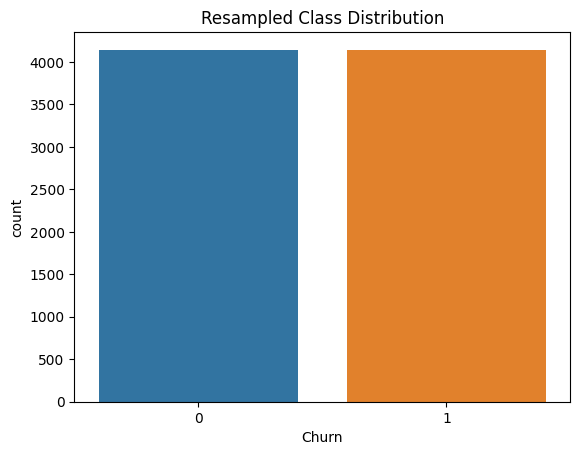

Churn
0    4144
1    4144
Name: count, dtype: int64


In [25]:
#HANDLING DATA IMBALANCE
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
smote = SMOTE(sampling_strategy="minority", k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
sns.countplot(x=y_train_resampled)
plt.title('Resampled Class Distribution')
plt.show()
print(y_train_resampled.value_counts())

In [26]:
#Modelling
models = [
    ("LR", LogisticRegression(random_state=12345)),
    ("KNN", KNeighborsClassifier()),
    ("CART", DecisionTreeClassifier(random_state=12345)),
    ("RF", RandomForestClassifier()),
    ("SVM", SVC(gamma="auto", probability=True, random_state=12345)),  
    ("XGB", XGBClassifier(random_state=12345)),
    ("LGM", LGBMClassifier(random_state=12345)),
    ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))
]

models_df = pd.DataFrame(columns=['Model', " Accuracy", ' f1', ' Precision', ' Recall', ' ROC AUC'])

for name, model in models:
    model.fit(X_train_resampled, y_train_resampled)
    

    y_pred = model.predict(X_test)
    

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
   
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = "N/A"  
    print(f"######{name}###########")
    print(classification_report(y_test,y_pred))
    models_df.loc[len(models_df)] = [name, accuracy, f1, precision, recall, roc_auc]



models_df

######LR###########
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1030
           1       0.57      0.61      0.59       379

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.72      1409
weighted avg       0.78      0.77      0.78      1409

######KNN###########
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1030
           1       0.49      0.74      0.59       379

    accuracy                           0.72      1409
   macro avg       0.69      0.73      0.69      1409
weighted avg       0.78      0.72      0.74      1409

######CART###########
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1030
           1       0.47      0.52      0.49       379

    accuracy                           0.71      1409
   macro avg       0.64      0.65      0.65      1409
weighted av

,Model,Accuracy,f1,Precision,Recall,ROC AUC
0,LR,0.772889,0.775035,0.777652,0.772889,0.823839
1,KNN,0.721079,0.735166,0.776921,0.721079,0.782000
2,CART,0.713982,0.718220,0.723532,0.713982,0.654452
3,RF,0.788502,0.788852,0.789215,0.788502,0.824327
4,SVM,0.773598,0.782683,0.805477,0.773598,0.811046
5,XGB,0.763662,0.764530,0.765464,0.763662,0.813063
6,LGM,0.774308,0.774865,0.775451,0.774308,0.821540
7,CatBoost,0.767211,0.769583,0.772500,0.767211,0.823561


In [27]:
######################################################
#  Automated Hyperparameter Optimization
###################################################### 
log_params={
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],        
    'solver': ['liblinear', 'lbfgs'] 
}
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],              
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500],
               "colsample_bytree": [0.5, 0.7, 1] }

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}
xgboost_params = {"learning_rate": [0.1, 0.01, 0.001],
                  "max_depth": [5, 8, 12, 15, 20],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.5, 0.7, 1]}
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


classifiers = [("LR",LogisticRegression(),log_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('GBM', GradientBoostingClassifier(), gbm_params),
               ('LightGBM', LGBMClassifier(), lgbm_params),
               ("XGBoost", XGBClassifier(random_state=17),xgboost_params),
               ("Cat",CatBoostClassifier(),catboost_params)

              ]

best_models = {}
results_df = pd.DataFrame(columns=['Model', " Accuracy", ' f1', ' Precision', ' Recall', ' ROC AUC', 'Best Params'])


for name, classifier, params in classifiers:
    
    gs_best = GridSearchCV(classifier, params, cv=3, n_jobs=-1, verbose=False).fit(X_train_resampled, y_train_resampled)
    final_model = classifier.set_params(**gs_best.best_params_)
    final_model=final_model.fit(X_train_resampled,y_train_resampled)
    y_pred=final_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = "N/A"

    best_params = gs_best.best_params_
    results_df.loc[len(results_df)] = [name, accuracy, f1, precision, recall, roc_auc, best_params]
    print(f"########{name}#########")
    print(classification_report(y_test,y_pred))
    best_models[name] = final_model
results_df

########LR#########
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1030
           1       0.59      0.63      0.60       379

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.73      1409
weighted avg       0.79      0.78      0.78      1409

########RF#########
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1030
           1       0.57      0.66      0.61       379

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.77      0.78      1409

########GBM#########
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1030
           1       0.59      0.57      0.58       379

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg 

,Model,Accuracy,f1,Precision,Recall,ROC AUC,Best Params
0,LR,0.779986,0.782228,0.785030,0.779986,0.823561,"{'C': 100, 'penalty': 'l1', 'solver': 'libline..."
1,RF,0.774308,0.779060,0.786512,0.774308,0.823561,"{'max_depth': 15, 'max_features': 3, 'min_samp..."
2,GBM,0.778566,0.777032,0.775717,0.778566,0.823561,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es..."
3,LightGBM,0.770050,0.771348,0.772807,0.770050,0.823561,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
4,XGBoost,0.779276,0.780262,0.781350,0.779276,0.823561,"{'colsample_bytree': 0.5, 'learning_rate': 0.0..."
5,Cat,0.770759,0.771044,0.771336,0.770759,0.823561,"{'depth': 6, 'iterations': 500, 'learning_rate..."


In [33]:

lr=best_models["LR"]

rf=RandomForestClassifier()
xgb=best_models["XGBoost"]

voting_clf = VotingClassifier(
    estimators=[
        ('LR', lr),
        ("xgb",xgb),
        ("rf",rf)
    ],
    voting='soft' 
)
voting_clf=voting_clf.fit(X_train_resampled,y_train_resampled)
y_pred=voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy:", accuracy)
print(f"F1: {round(f1, 4)}")
print(f"Precision: {round(precision, 4)}")
print(f"Recall: {round(recall, 4)}")
print(classification_report(y_pred,y_test))



Accuracy: 0.7877927608232789
F1: 0.7889
Precision: 0.7902
Recall: 0.7878
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1017
           1       0.62      0.60      0.61       392

    accuracy                           0.79      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



I choose voting_clf as final model with better results


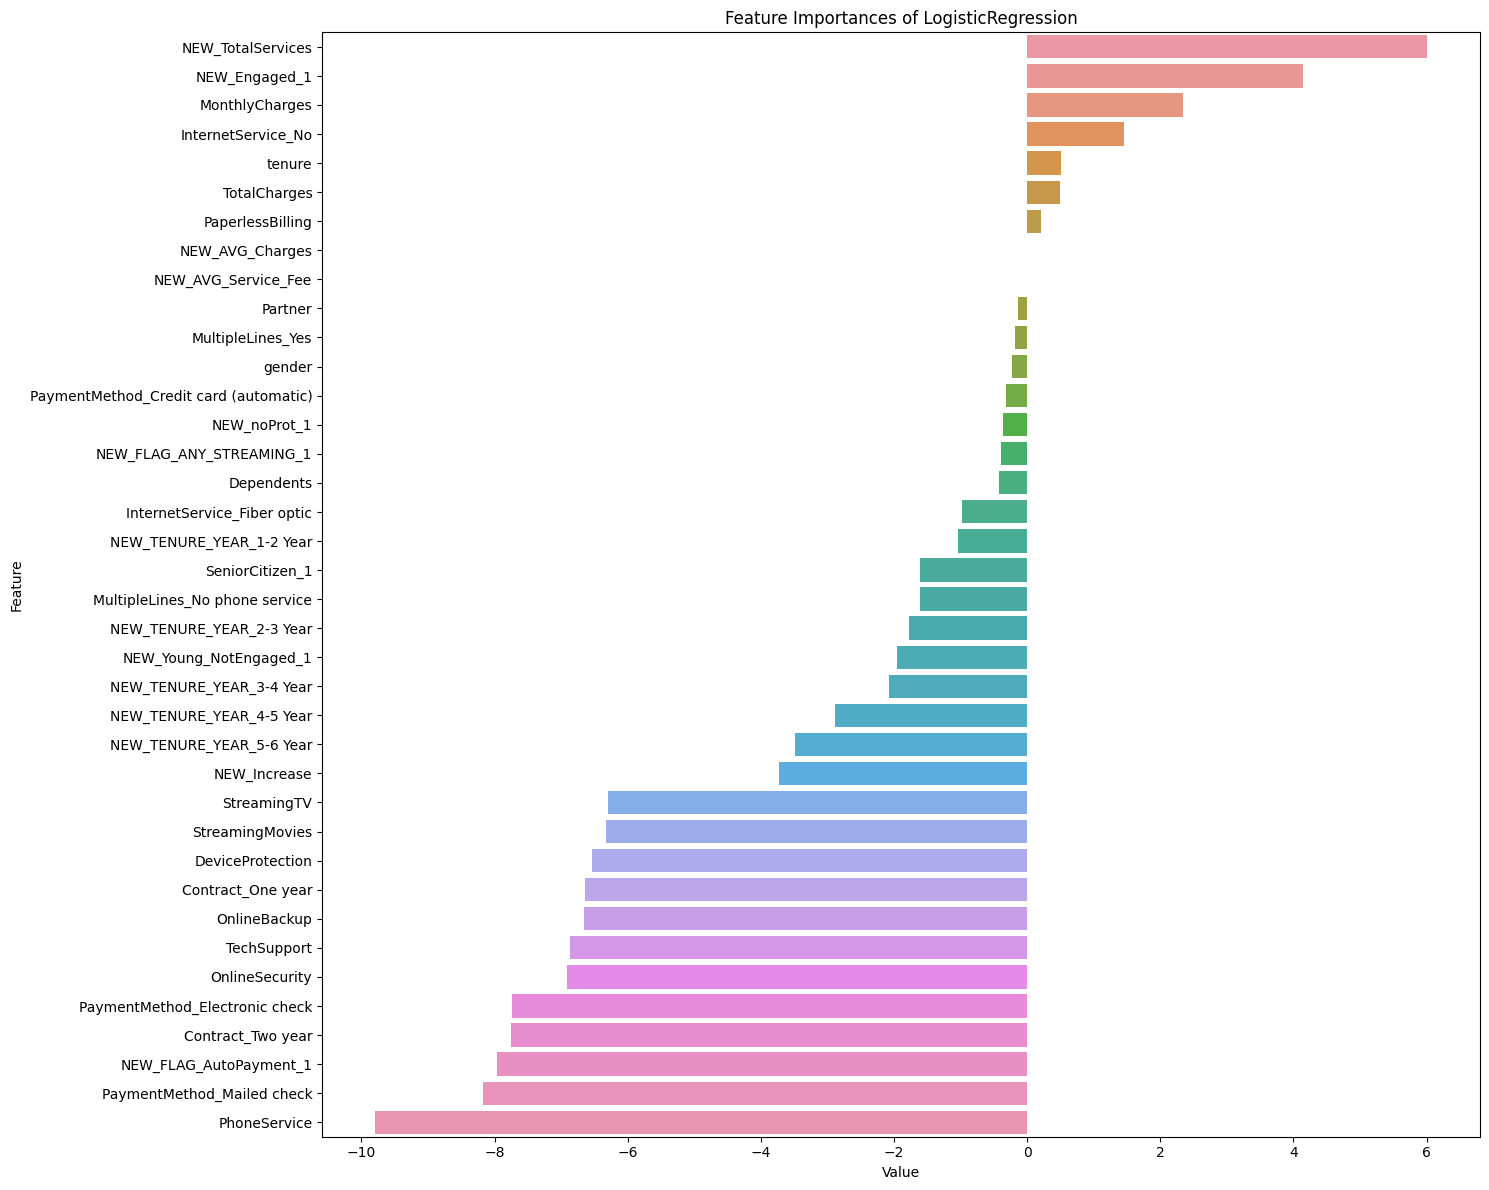

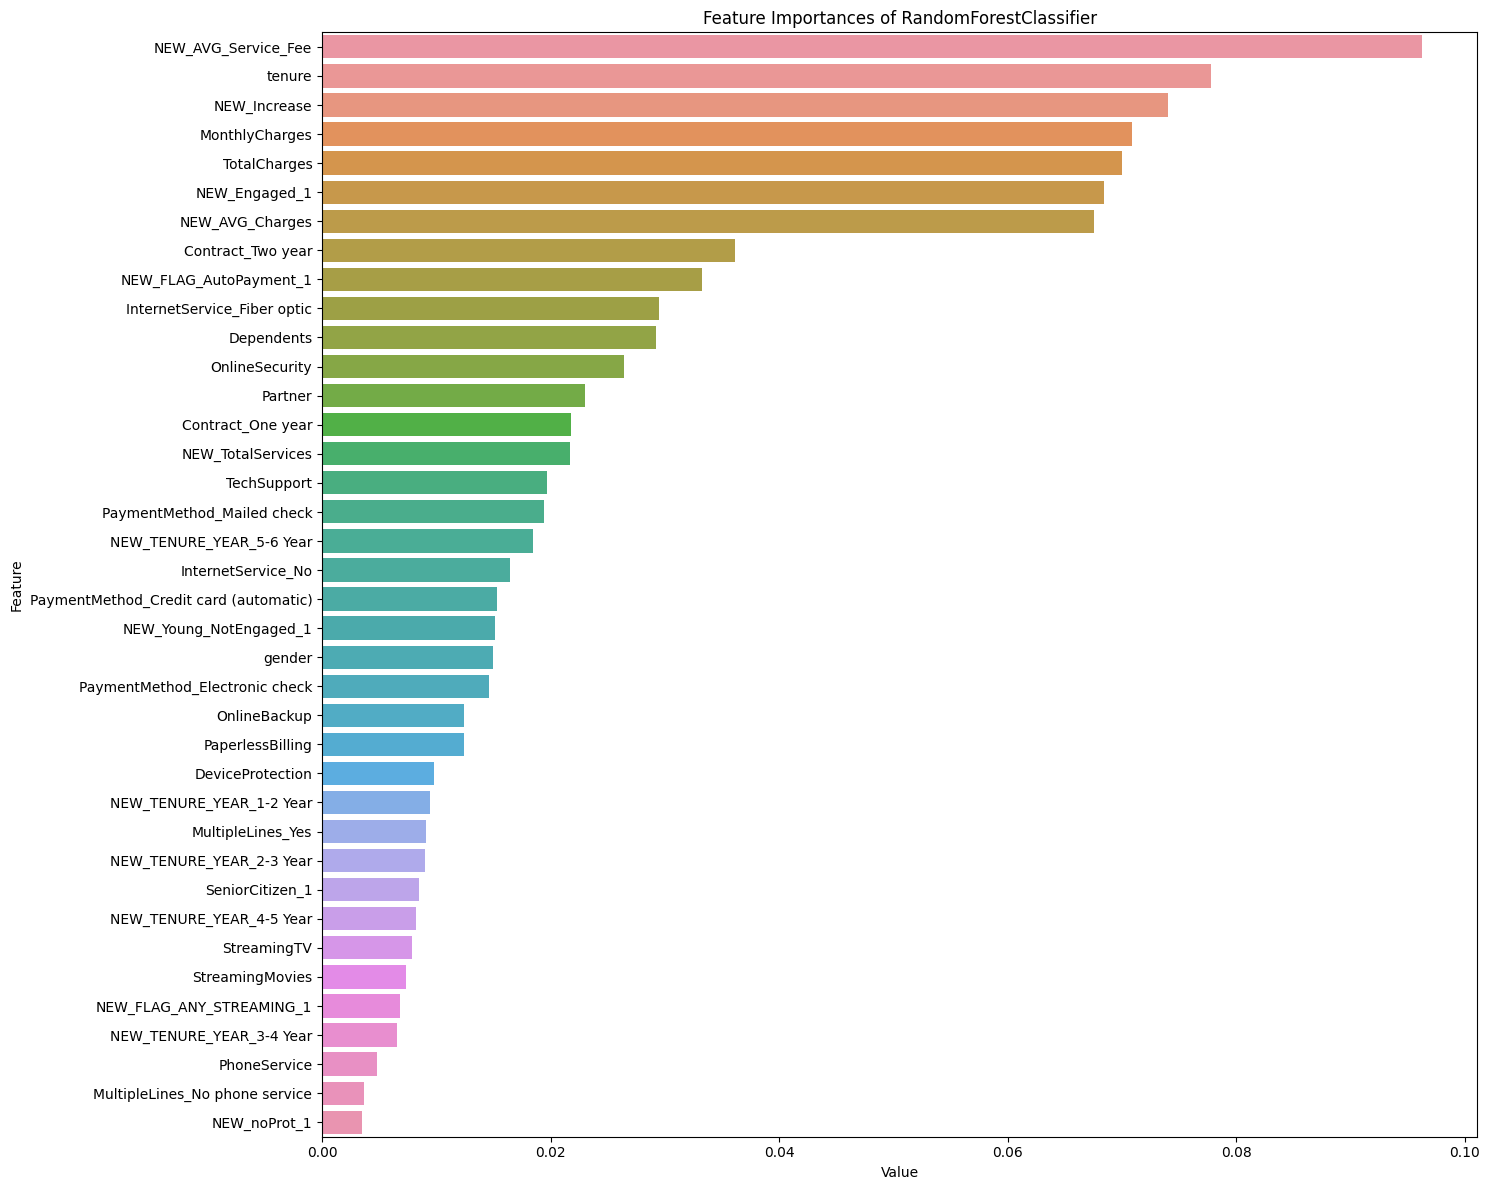

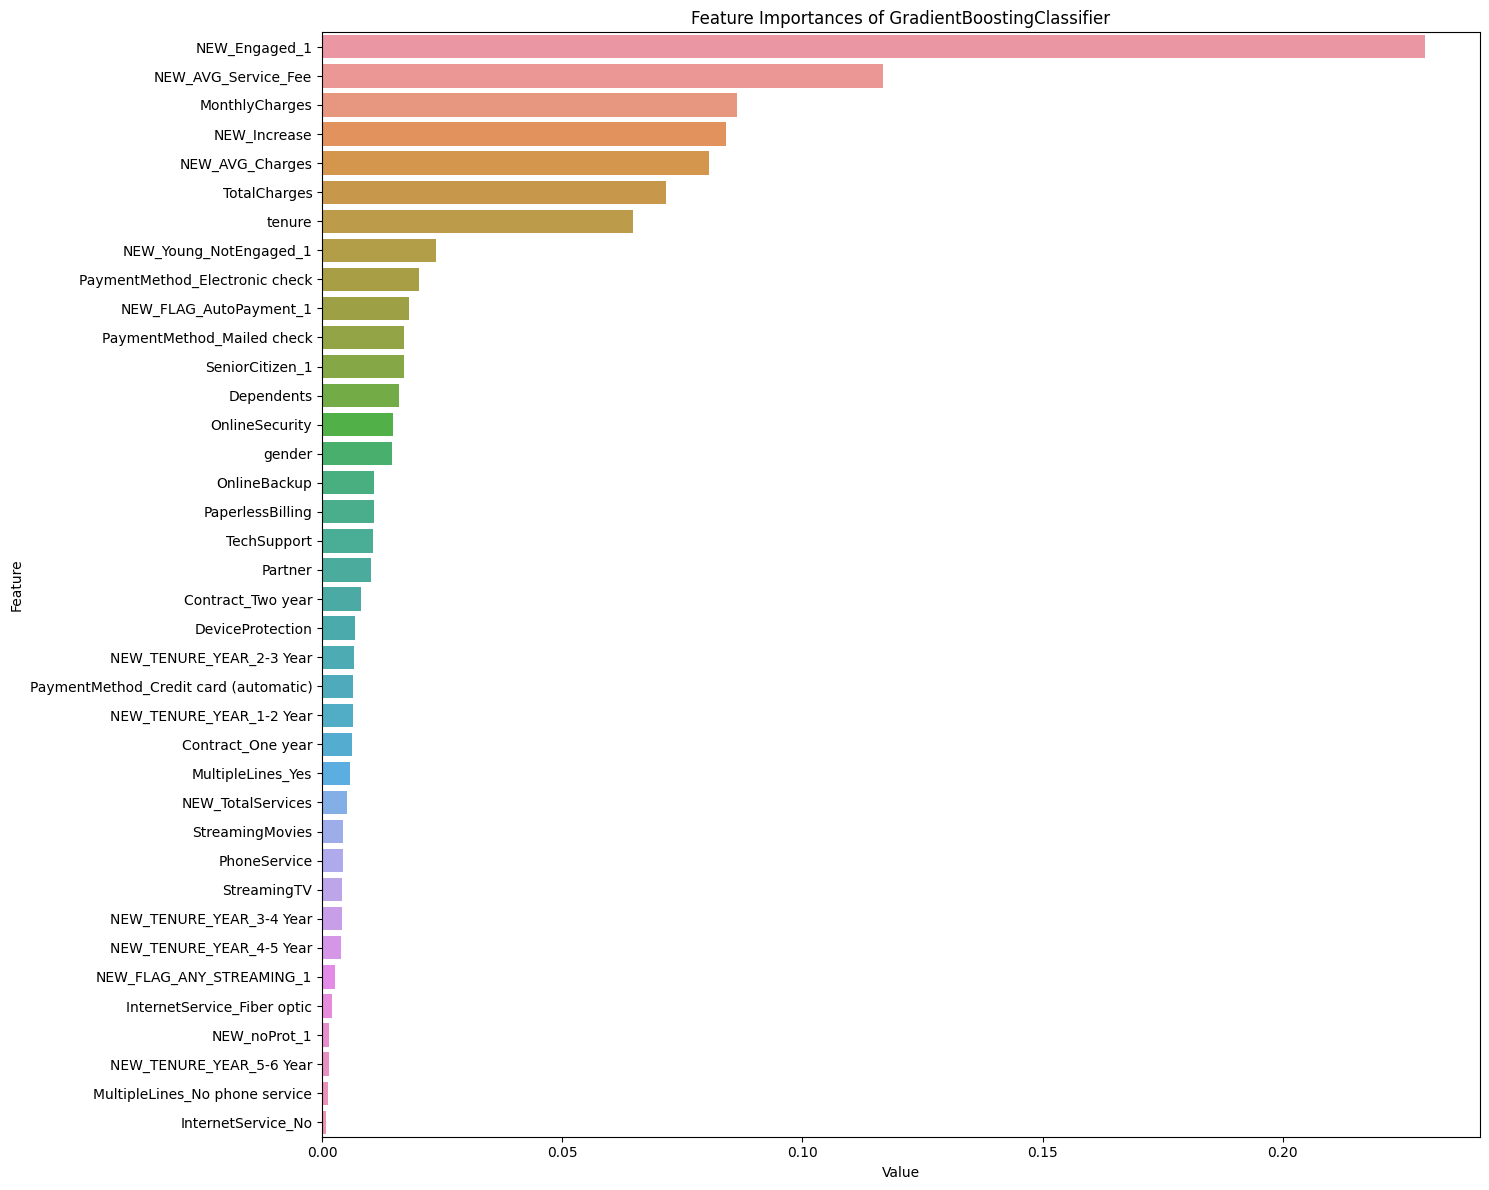

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4144, number of negative: 4144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the train set: 8288, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


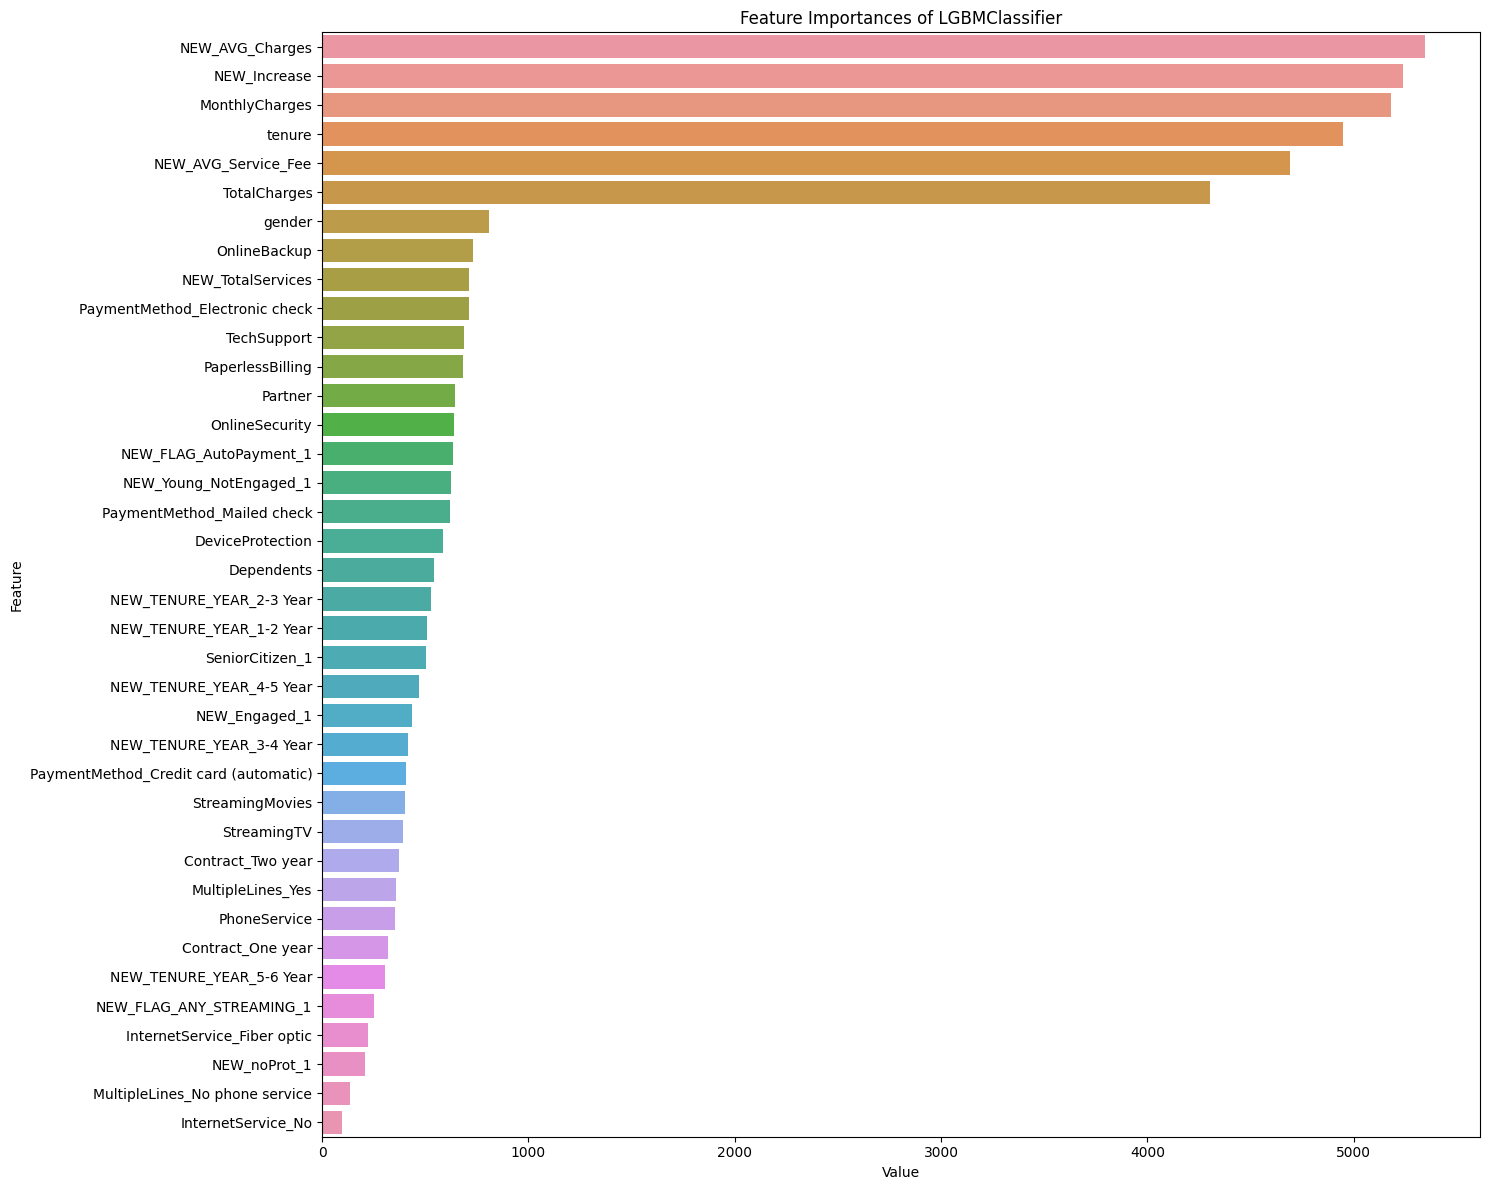

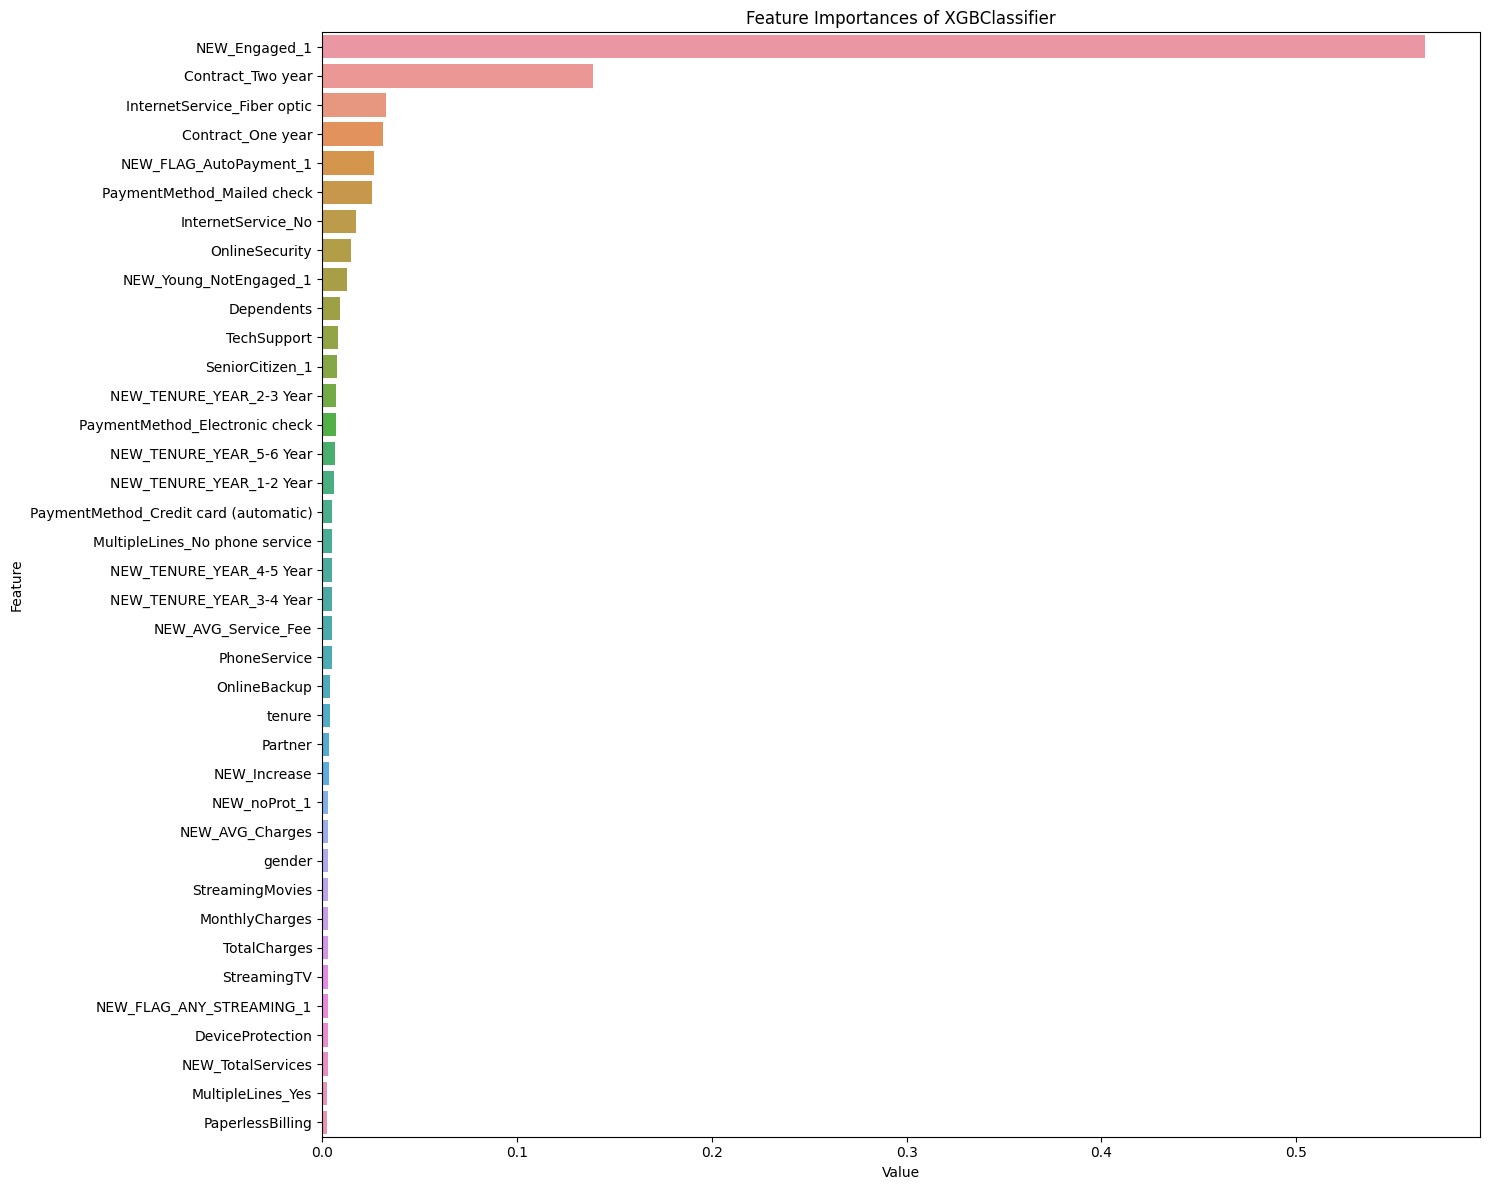

0:	learn: 0.6392716	total: 6.81ms	remaining: 3.4s
1:	learn: 0.6039089	total: 13.3ms	remaining: 3.31s
2:	learn: 0.5722708	total: 18.7ms	remaining: 3.09s
3:	learn: 0.5347330	total: 25ms	remaining: 3.1s
4:	learn: 0.4979110	total: 30.4ms	remaining: 3.01s
5:	learn: 0.4828066	total: 36ms	remaining: 2.96s
6:	learn: 0.4709253	total: 42.8ms	remaining: 3.01s
7:	learn: 0.4513992	total: 48.6ms	remaining: 2.99s
8:	learn: 0.4418536	total: 54.7ms	remaining: 2.98s
9:	learn: 0.4347611	total: 60.8ms	remaining: 2.98s
10:	learn: 0.4276618	total: 66.5ms	remaining: 2.96s
11:	learn: 0.4215436	total: 74.3ms	remaining: 3.02s
12:	learn: 0.4156854	total: 81.5ms	remaining: 3.05s
13:	learn: 0.4112060	total: 88.3ms	remaining: 3.06s
14:	learn: 0.4073653	total: 94.4ms	remaining: 3.05s
15:	learn: 0.4044285	total: 101ms	remaining: 3.05s
16:	learn: 0.4007365	total: 106ms	remaining: 3.02s
17:	learn: 0.3974517	total: 112ms	remaining: 3.01s
18:	learn: 0.3945085	total: 119ms	remaining: 3s
19:	learn: 0.3921822	total: 124ms	r

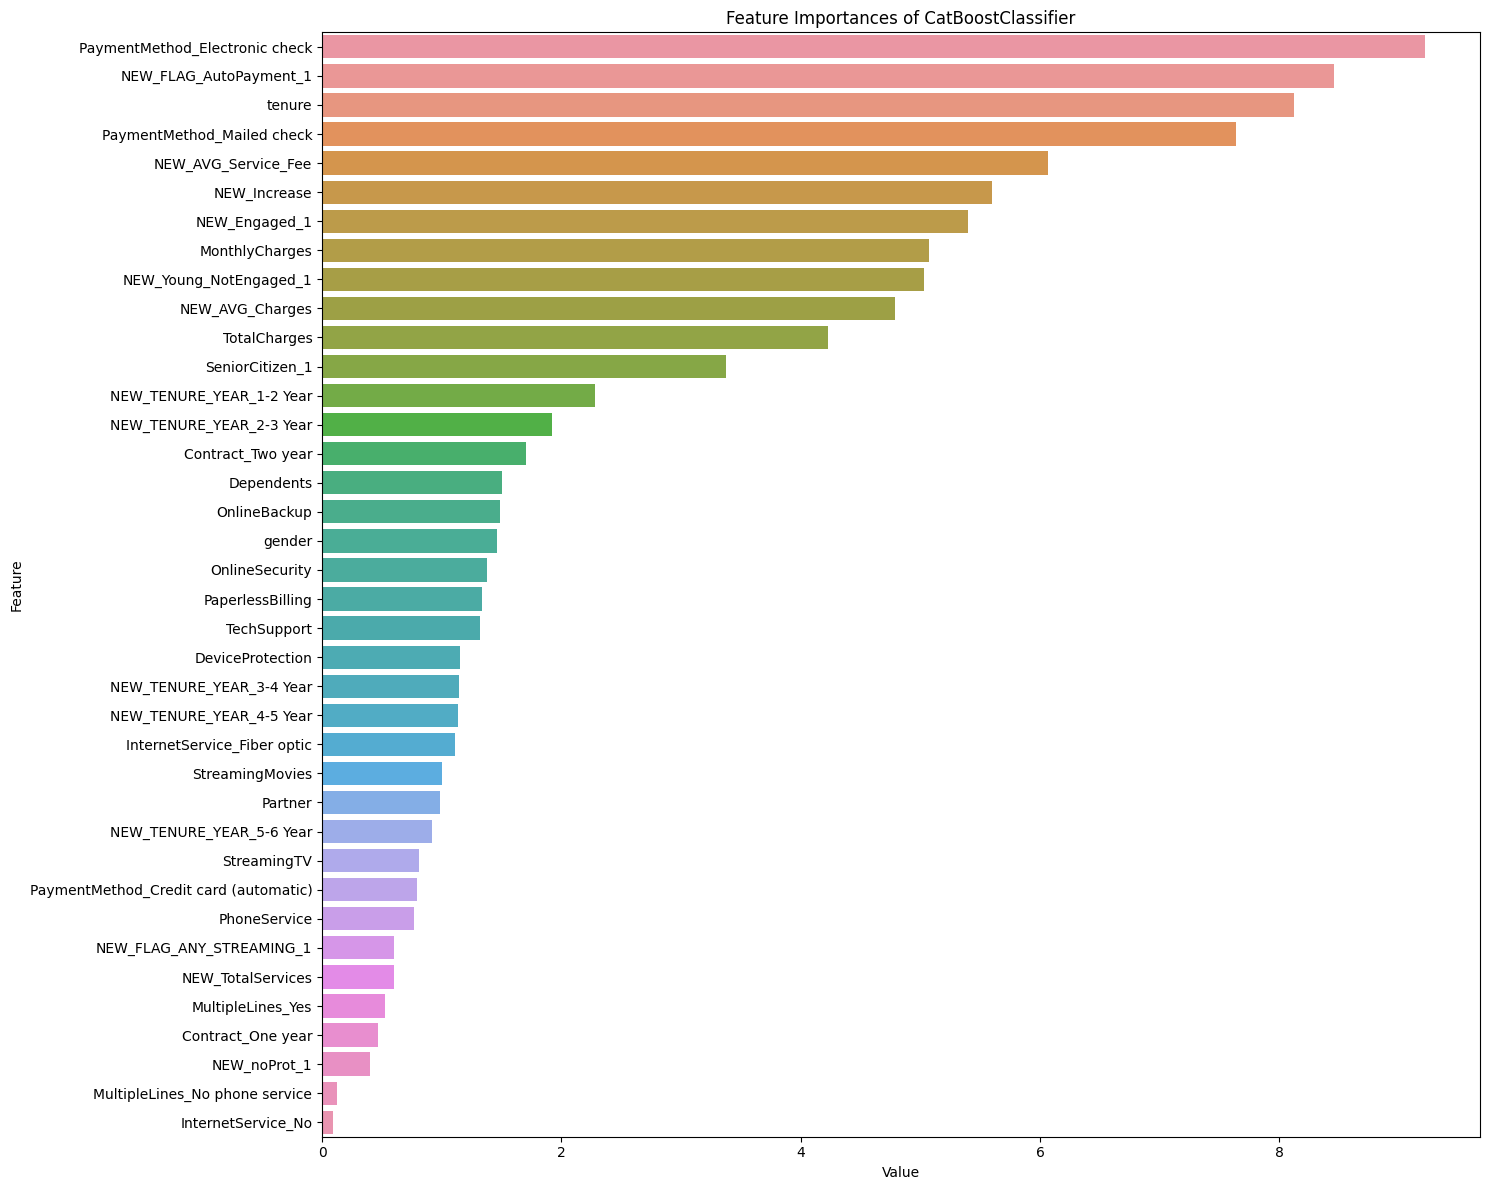

In [29]:


def plot_importances(model, features, num=None, save=False):
    if num is None:
        num = len(features.columns)

    # Check if the model has feature_importances_
    if hasattr(model, 'feature_importances_'):
        feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    elif hasattr(model, 'coef_'):
        feature_imp = pd.DataFrame({"Value": model.coef_[0], "Feature": features.columns})
    else:
        raise ValueError("The model does not have feature importances or coefficients.")
    
    plt.figure(figsize=(15, 12))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(num))
    plt.title(f'Feature Importances of {type(model).__name__}')
    plt.tight_layout()
    
    if save:
        plt.savefig('feature_importances.png')
    
    plt.show()

for model_name in best_models:
    final_model = best_models[model_name].fit(X_train_resampled,y_train_resampled)
    plot_importances(final_model, X)


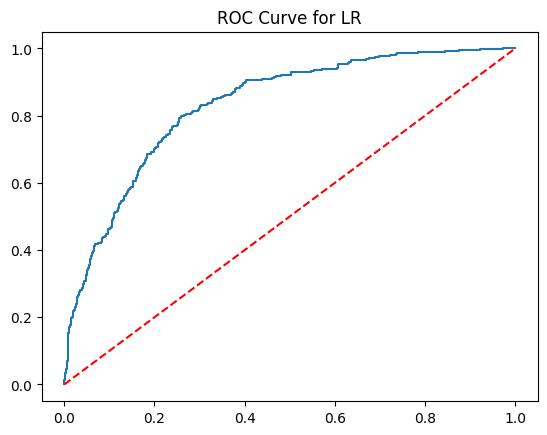

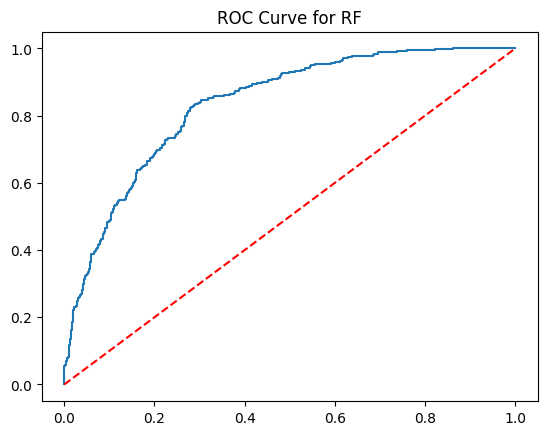

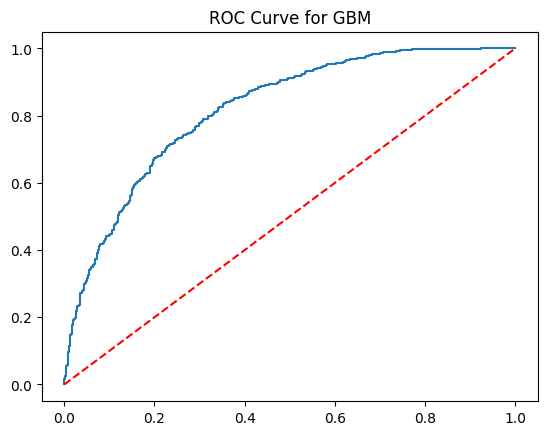

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4144, number of negative: 4144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1600
[LightGBM] [Info] Number of data points in the train set: 8288, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


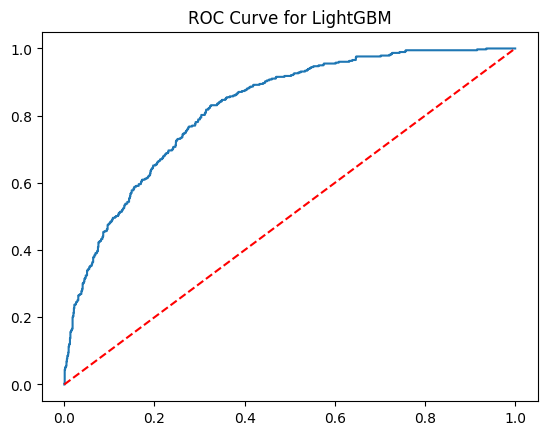

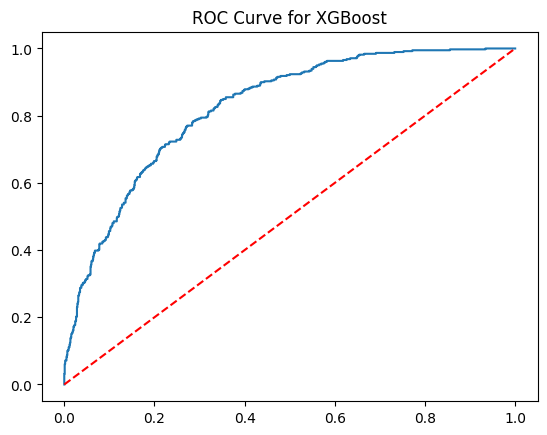

0:	learn: 0.6392716	total: 6.74ms	remaining: 3.36s
1:	learn: 0.6039089	total: 12.3ms	remaining: 3.06s
2:	learn: 0.5722708	total: 18.6ms	remaining: 3.09s
3:	learn: 0.5347330	total: 24.2ms	remaining: 3s
4:	learn: 0.4979110	total: 30.3ms	remaining: 3s
5:	learn: 0.4828066	total: 36ms	remaining: 2.97s
6:	learn: 0.4709253	total: 41.5ms	remaining: 2.92s
7:	learn: 0.4513992	total: 47.6ms	remaining: 2.92s
8:	learn: 0.4418536	total: 53.5ms	remaining: 2.92s
9:	learn: 0.4347611	total: 59.4ms	remaining: 2.91s
10:	learn: 0.4276618	total: 66.1ms	remaining: 2.94s
11:	learn: 0.4215436	total: 75.4ms	remaining: 3.07s
12:	learn: 0.4156854	total: 82.7ms	remaining: 3.1s
13:	learn: 0.4112060	total: 89.5ms	remaining: 3.11s
14:	learn: 0.4073653	total: 110ms	remaining: 3.57s
15:	learn: 0.4044285	total: 116ms	remaining: 3.52s
16:	learn: 0.4007365	total: 123ms	remaining: 3.49s
17:	learn: 0.3974517	total: 129ms	remaining: 3.44s
18:	learn: 0.3945085	total: 135ms	remaining: 3.41s
19:	learn: 0.3921822	total: 141ms	re

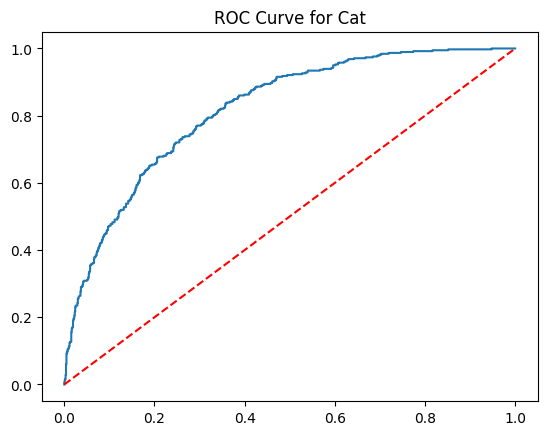

In [30]:

def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', color='r')
    plt.title(f"ROC Curve for {model_name}")
    plt.show()

for model_name, model in best_models.items():
    model=model.fit(X_train_resampled,y_train_resampled)
    generate_auc_roc_curve(model,X_test)